In [1]:
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import KFold
import wandb

from data_loader import load_data, get_balanced_data, normalize_features, DATA_FEATURE_NAMES_LIST, concat_group_data

USE_CONCAT_CTS = False
USE_CT = 'CA1-ProS_Glut'
# USE_CT = 'CA1-ProS_Glut'
# MODALITY_INCLUDED = 'all'
# MODALITY_INCLUDED = 'methylation'
MODALITY_INCLUDED = 'hic'
# MODALITY_INCLUDED = 'hic'
if USE_CONCAT_CTS:
    CTS = ['L23_IT_CTX_Glut', 'L6_CT_CTX_Glut', 'L5_ET_CTX_Glut','L6_IT_CTX_Glut','Oligo_NN','Pvalb_Gaba'] #
    CT = ','.join(CTS)
    X_balanced, y_balanced, gene_list = concat_group_data(CT)
else:
    CT = USE_CT
    data = load_data(ct=CT)
    X_balanced, y_balanced, gene_list = get_balanced_data(data)


ML_OUTPUT_DIR = f'ml_output/{CT}'
if MODALITY_INCLUDED != 'all':
    ML_OUTPUT_DIR = f'ml_output/{CT}/{MODALITY_INCLUDED}'
os.makedirs(ML_OUTPUT_DIR, exist_ok=True)

assert len(y_balanced) == len(gene_list)

if MODALITY_INCLUDED == 'all':
    FEATURE_MODALITIES = DATA_FEATURE_NAMES_LIST
elif MODALITY_INCLUDED == 'methylation':
    FEATURE_MODALITIES = ['dmr', 'mcg_genebody', 'mch_genebody']
elif MODALITY_INCLUDED == 'atac':
    FEATURE_MODALITIES = ['atac']
elif MODALITY_INCLUDED == 'hic':
    FEATURE_MODALITIES = ['hic_loop', 'hic_abc_dmr', 'hic_abc_peak']
else:
    raise ValueError(f'{MODALITY_INCLUDED} is not a valid modality')
    

for k, v in X_balanced.items():
    print(k, len(v))
# y_balanced = y_balanced[:, 2]
# print('zero:', (y_balanced == 0).sum(), 'non-zero:', (y_balanced != 0).sum())

Processed dmr data
Processed mCH genebody data
Processed mCG genebody data
Processed atac data
Processed abc dmr data
Processed abc peak data
Processed hic loop data
Preparing data
zero: 6930, non-zero: 1219
Getting balanced data
dmr 1828
mcg_genebody 1828
mch_genebody 1828
atac 1828
hic_loop 1828
hic_abc_dmr 1828
hic_abc_peak 1828


In [2]:
assert len(y_balanced) == len(gene_list)


In [3]:
# check how many  0 , -1 and 1 in y_balanced
print('y_balanced 0:', np.sum(y_balanced == 0))
print('y_balanced -1:', np.sum(y_balanced == -1))
print('y_balanced 1:', np.sum(y_balanced == 1))


y_balanced 0: 609
y_balanced -1: 467
y_balanced 1: 752


In [4]:
import wandb

In [5]:
import os
# 68%
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 4
TEMPERATURE = 1.0
DROPOUT = 0.15
LR = 3e-3
OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
NUM_EPOCHS = 20
BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 4
# NUM_HEADS = 8
# DROPOUT = 0.0
# LR = 0.03
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 20
# BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 1
# NUM_HEADS = 1
# DROPOUT = 0.3
# LR = 1e-4
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 200
# BATCH_SIZE = 16


class MultiModalityTransformerModel(nn.Module):
    def __init__(self, modality_input_dims, hidden_dim, output_dim, num_layers=2, num_heads=1, dropout=0.1, temperature=1.0):
        super(MultiModalityTransformerModel, self).__init__()
        self.cls_embeddings = nn.ParameterDict({modality: nn.Parameter(torch.randn(1, 1, hidden_dim)) for modality in FEATURE_MODALITIES})
        self.modality_embeddings = nn.ModuleDict({modality: nn.Linear(modality_input_dims[modality], hidden_dim) for modality in FEATURE_MODALITIES})

        # TODO: may need to use tanh in attention instead of softmax
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True, norm_first=True)
        self.modality_transformers = nn.ModuleDict({modality: nn.TransformerEncoder(encoder_layers, num_layers) for modality in FEATURE_MODALITIES})

        # Add one dimension for the sequence length
        self.batch_norms = nn.ModuleDict({modality: nn.BatchNorm1d(hidden_dim + 1) for modality in FEATURE_MODALITIES})
        
        # Use self-attention mechanism to combine the outputs of the four heads
        self.temperature = temperature
        self.query = nn.Parameter(torch.randn(1, hidden_dim))
        self.key_layer = nn.Linear(hidden_dim + 1, hidden_dim)
        self.value_layer = nn.Linear(hidden_dim + 1, hidden_dim)
        self.attn_output_norm = nn.BatchNorm1d(hidden_dim)
        self.attn_output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim),
            )
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Parameter):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


        

    def forward(self, x_dict, mask_dict, get_attn_weights=False):
        # Add cls embedding, so that we can take the first output as the representation of the sequence
        modality_cls_embeddings = {modality: self.cls_embeddings[modality].repeat(x_dict[modality].size(0), 1, 1) for modality in FEATURE_MODALITIES}


        modality_embeddings = {modality: self.modality_embeddings[modality](x_dict[modality]) for modality in FEATURE_MODALITIES}

        modality_embeddings = {modality: torch.cat((modality_cls_embeddings[modality], modality_embeddings[modality]), dim=1) for modality in FEATURE_MODALITIES}

        modality_masks = {modality: torch.cat((torch.ones(mask_dict[modality].size(0), 1), mask_dict[modality]), dim=1) for modality in FEATURE_MODALITIES}

        modality_outputs = {modality: self.modality_transformers[modality](modality_embeddings[modality], src_key_padding_mask=~modality_masks[modality].bool()) for modality in FEATURE_MODALITIES}

        seq_lengths = {modality: torch.log(1 + mask_dict[modality].sum(dim=1).unsqueeze(-1)) for modality in FEATURE_MODALITIES}
        # Pooling, we should not use average pooling since the sequence length is also important
        modality_outputs = {modality: torch.cat((modality_outputs[modality][:, 0, :], seq_lengths[modality]), dim=1) for modality in FEATURE_MODALITIES}

        modality_outputs = {modality: self.batch_norms[modality](modality_outputs[modality]) for modality in FEATURE_MODALITIES}

        # Combine the output of four heads into a sequence
        combined_x = torch.stack([modality_outputs[modality] for modality in FEATURE_MODALITIES], dim=1) # (batch_size, M, hidden_dim)

        # self-attention
        keys = self.key_layer(combined_x) # [N, M, d]
        values = self.value_layer(combined_x) # [N, M, d]
        query = self.query.expand(combined_x.size(0), -1).unsqueeze(-1)  # [N, d, 1]
        attn_scores = torch.matmul(keys, query).squeeze(-1)  # [N, M]
        # Devided by sqrt(d) to smooth the attention scores
        attn_scores = attn_scores / self.temperature / torch.sqrt(torch.tensor(keys.size(-1), dtype=torch.float32))
        attn_weights = F.softmax(attn_scores, dim=-1)  # [N, M]

        combined_x = torch.sum(values * attn_weights.unsqueeze(-1), dim=1) # [N, d]
        combined_x = self.attn_output_norm(combined_x)
        residual = combined_x
        combined_x = self.attn_output_layer(combined_x) 
        combined_x += residual
    
        output = self.classifier(combined_x)
        if get_attn_weights:
            return output, attn_weights
        else:
            return output

class CombinedGeneDataset(Dataset):
    def __init__(self, x_dict, labels):
        self.x_dict = x_dict
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        x_dict = {modality: torch.FloatTensor(self.x_dict[modality][idx]) for modality in FEATURE_MODALITIES} # [M, seq_len, D]
        label = torch.LongTensor([self.labels[idx].item() + 1])  # Add 1 to shift labels to 0, 1, 2
        return x_dict, label

def combined_collate_fn_no_sort(batch):
    x_list, labels = zip(*batch) # x_dict: {modality: [N, seq_len, D]}

    # Permute the dimensions of x_list to [M, N, seq_len, D]
    batched_x_dict = {modality: [x_list[i][modality] for i in range(len(x_list))] for modality in FEATURE_MODALITIES}

    modality_lengths = {modality: [len(seq) for seq in batched_x_dict[modality]] for modality in FEATURE_MODALITIES} # [N, M]
    modality_max_len = {modality: max(modality_lengths[modality]) for modality in FEATURE_MODALITIES} # [M]
    padded_x_dict = {modality: torch.zeros(len(batched_x_dict[modality]), modality_max_len[modality], batched_x_dict[modality][0].size(1)) for modality in FEATURE_MODALITIES} # [M, N, max_seq_len, D]
    padded_mask_dict = {modality: torch.zeros(len(batched_x_dict[modality]), modality_max_len[modality]) for modality in FEATURE_MODALITIES} # [M, N, max_seq_len]
    for modality, modality_seqs in batched_x_dict.items():
        for batch_idx, (seq, length) in enumerate(zip(modality_seqs, modality_lengths[modality])):
            padded_x_dict[modality][batch_idx, :length] = seq
            padded_mask_dict[modality][batch_idx, :length] = 1
    return padded_x_dict, padded_mask_dict, torch.cat(labels)

def combined_collate_fn(batch):
    batch.sort(key=lambda x: len(x[0][FEATURE_MODALITIES[0]]), reverse=True)
    return combined_collate_fn_no_sort(batch)

def train_combined_model(X_train_dict, y_train, X_test_dict, y_test, exp_name, fold_idx):
    #wandb.init(project='gene', group=exp_name, name=f'fold-{fold_idx}')
    modality_input_dims = {modality: len(X_train_dict[modality][0][0]) for modality in FEATURE_MODALITIES} 

    train_dataset = CombinedGeneDataset(X_train_dict, y_train)
    test_dataset = CombinedGeneDataset(X_test_dict, y_test)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=combined_collate_fn, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=combined_collate_fn_no_sort)

    model = MultiModalityTransformerModel(modality_input_dims, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT)

    from sklearn.utils.class_weight import compute_class_weight

    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weights = torch.FloatTensor(class_weights)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    # optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    # lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-3)
    lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS, final_div_factor=10)

    # Create the OneCycleLR scheduler
    # lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, total_steps=NUM_EPOCHS,
    #                           pct_start=0.8, anneal_strategy='cos',
    #                           cycle_momentum=False, div_factor=5.0,
    #                           final_div_factor=10.0)

    def evaluate(model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_list, mask_list, batch_y in test_loader:
                outputs = model(x_list, mask_list)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.squeeze()).sum().item()
        return correct / total
    
    print(f'Initial Test Accuracy: {evaluate(model):.4f}')

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        for x_list, mask_list, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(x_list, mask_list)
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y.squeeze()).sum().item()
            train_total += batch_y.size(0)

        accuracy = evaluate(model)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Accuracy: {accuracy:.4f}')

        wandb.log({'epoch': epoch, 'LR': optimizer.param_groups[0]['lr'], 'train_loss': total_loss/len(train_loader), 'train_accuracy': train_correct/train_total, 'test_accuracy': accuracy})

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for x_list, mask_list, batch_y in test_loader:
            outputs = model(x_list, mask_list)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_accuracy = sum(np.array(all_predictions) == np.array(all_labels).squeeze()) / len(all_labels)
    print(f'Final Test Accuracy: {final_accuracy:.4f}')
    return final_accuracy, all_predictions, all_labels, model

In [ ]:
import time
exp_name = f'multi-modality-{time.strftime("%Y%m%d-%H%M%S")}'
wandb.init(project='gene', group=exp_name, name=exp_name, settings=wandb.Settings(code_dir="."))

wandb.config.update({
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'num_heads': NUM_HEADS,
    'dropout': DROPOUT,
    'lr': LR,
    'output_dim': OUTPUT_DIM,
    'num_epochs': NUM_EPOCHS,
})


# Fix the random seed
torch.manual_seed(25)
np.random.seed(25)
kf = KFold(n_splits=5, shuffle=True, random_state=25)
accuracies = []
k_fold_indices = []
for i, (train_index, test_index) in enumerate(kf.split(X_balanced[FEATURE_MODALITIES[0]])):
    k_fold_indices.append((train_index, test_index))
    X_train_dict = {modality: [X_balanced[modality][i] for i in train_index] for modality in FEATURE_MODALITIES}
    X_test_dict = {modality: [X_balanced[modality][i] for i in test_index] for modality in FEATURE_MODALITIES}
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]

    X_train_normalized_dict = {}
    X_test_normalized_dict = {}
    for modality in FEATURE_MODALITIES:
        X_train_normalized_dict[modality], X_test_normalized_dict[modality] = normalize_features(X_train_dict[modality], X_test_dict[modality])
    
    acc, preds, labels, model = train_combined_model(X_train_normalized_dict, y_train, X_test_normalized_dict, y_test, exp_name=exp_name, fold_idx=i)
    torch.save(model.state_dict(), f'{ML_OUTPUT_DIR}/model_{i}.pth')
    accuracies.append(acc)


    # acc, preds, labels, model = train_combined_model(X_train_dmr_normalized, X_train_atac_normalized, X_train_hic_normalized, X_train_genebody_normalized, y_train,
    #                                           X_test_dmr_normalized, X_test_atac_normalized, X_test_hic_normalized, X_test_genebody_normalized, y_test, exp_name=exp_name, fold_idx=i)
    # break

# print(f'Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

wandb: Currently logged in as: michaelvll to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/home/ubuntu/aging-gene-prediction/eat/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


Initial Test Accuracy: 0.2705
Epoch [1/20], Train Loss: 1.6700, Train Accuracy: 0.3417, Test Accuracy: 0.4317
Epoch [2/20], Train Loss: 1.3762, Train Accuracy: 0.3569, Test Accuracy: 0.4071
Epoch [3/20], Train Loss: 1.2238, Train Accuracy: 0.4097, Test Accuracy: 0.4699
Epoch [4/20], Train Loss: 1.2257, Train Accuracy: 0.4076, Test Accuracy: 0.4126
Epoch [5/20], Train Loss: 1.1729, Train Accuracy: 0.4194, Test Accuracy: 0.5109
Epoch [6/20], Train Loss: 1.1448, Train Accuracy: 0.4160, Test Accuracy: 0.4590
Epoch [7/20], Train Loss: 1.1043, Train Accuracy: 0.4542, Test Accuracy: 0.4481
Epoch [8/20], Train Loss: 1.0940, Train Accuracy: 0.4674, Test Accuracy: 0.4290
Epoch [9/20], Train Loss: 1.0659, Train Accuracy: 0.4910, Test Accuracy: 0.4645
Epoch [10/20], Train Loss: 1.0340, Train Accuracy: 0.4972, Test Accuracy: 0.4645
Epoch [11/20], Train Loss: 1.0397, Train Accuracy: 0.5049, Test Accuracy: 0.4699
Epoch [12/20], Train Loss: 1.0148, Train Accuracy: 0.5076, Test Accuracy: 0.4891
Epoch [

In [7]:
# k_fold_indices = []
# kf = KFold(n_splits=5, shuffle=True, random_state=25)
# for i, (train_index, test_index) in enumerate(kf.split(X_balanced[FEATURE_MODALITIES[0]])):
#     k_fold_indices.append((train_index, test_index))

In [8]:
result_indices = []
all_preds = []
all_labels = []
attn_weights_list = []
all_gene_list = []
for i, (train_index, test_index) in enumerate(k_fold_indices):
    X_train_dict = {modality: [X_balanced[modality][i] for i in train_index] for modality in FEATURE_MODALITIES}
    X_test_dict = {modality: [X_balanced[modality][i] for i in test_index] for modality in FEATURE_MODALITIES}
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]

    X_train_normalized_dict = {}
    X_test_normalized_dict = {}
    for modality in FEATURE_MODALITIES:
        _, X_test_normalized_dict[modality] = normalize_features(X_train_dict[modality], X_test_dict[modality])
    modality_input_dims = {modality: len(X_test_normalized_dict[modality][0][0]) for modality in FEATURE_MODALITIES}

    model = MultiModalityTransformerModel(modality_input_dims, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT, temperature=TEMPERATURE)
    model.load_state_dict(torch.load(f'{ML_OUTPUT_DIR}/model_{i}.pth'))
    model.eval()

    test_dataset = CombinedGeneDataset(X_test_normalized_dict, y_test)
    test_gene_list = [gene_list[i] for i in test_index]
    all_gene_list.extend(test_gene_list)
    result_indices.extend(test_index)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=combined_collate_fn_no_sort)

    with torch.no_grad():
        for x_dict, mask_dict, batch_y in test_loader:
            outputs, attn_weights = model(x_dict, mask_dict, get_attn_weights=True)
            pred = outputs.argmax(dim=1).cpu().numpy()
            attn_weights = attn_weights.cpu().numpy()
            all_preds.extend(pred)
            all_labels.extend(batch_y.cpu().numpy())
            attn_weights_list.append(attn_weights) # [N, 4]

# all_gene_list = [gene_list[i] for i in result_indices]
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
attn_weights = np.concatenate(attn_weights_list, axis=0)
print(attn_weights.shape)

(2305, 3)


In [9]:
print(f'accuracy: {(all_preds == all_labels).sum() / len(all_preds):.2%}')


accuracy: 62.21%


In [10]:
import pandas as pd

if USE_CONCAT_CTS:
    celltype_list, all_gene_list = zip(*[i.split('+') for i in all_gene_list])
else:
    celltype_list = [CT] * len(all_gene_list)
result = pd.DataFrame({
    'cell_type': celltype_list,
    'gene': all_gene_list,
    'DEG': all_labels - 1,
    'pred': all_preds - 1,
    **{
        modality: attn_weights[:, i] for i, modality in enumerate(FEATURE_MODALITIES)
    }
})
result.to_csv(f'{ML_OUTPUT_DIR}/result.csv', index=False)


# Plot the attention weights (each attn_weight is a 4-dim vector)
# We should label each row with the pred and label, and each column with the
# modality name: dmr, atac, hic, genebody
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

# Find all the places where the prediction is correct
print(pd.Series(all_labels).value_counts())
print(pd.Series(all_preds).value_counts())

correct_idx = (all_preds == all_labels)
head = 100
correct_pos = np.where(correct_idx)[0][:head]

0    948
1    768
2    589
Name: count, dtype: int64
0    961
1    731
2    613
Name: count, dtype: int64


In [11]:
result[result['gene'] == 'Il33']

,cell_type,gene,DEG,pred,hic_loop,hic_abc_dmr,hic_abc_peak
385,Oligo_NN,Il33,1,1,0.295197,0.277572,0.427231


In [12]:
result[result['gene'] == 'Ubb']

,cell_type,gene,DEG,pred,hic_loop,hic_abc_dmr,hic_abc_peak
187,Oligo_NN,Ubb,-1,-1,0.032493,0.294576,0.672931


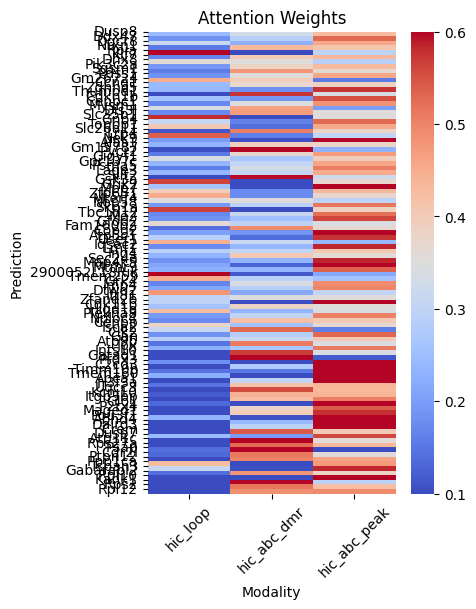

In [13]:
fig, ax = plt.subplots(figsize=(4, 6), dpi = 100)
ax = sns.heatmap(attn_weights[correct_pos, :], annot=False, fmt='.2f', cmap='coolwarm', vmin=0.1, vmax=0.6, ax=ax)

ax.set_xlabel('Modality')
ax.set_xticklabels(FEATURE_MODALITIES, rotation=45)
ax.set_ylabel('Prediction')
ax.set_yticks(range(len(correct_pos)))
ax.set_yticklabels([f'{test_gene_list[i]}' for i in correct_pos], rotation=0)
ax.set_title('Attention Weights')
plt.show()